In [28]:
from os.path import join
from typing import List

import IPython.display as display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from librosa.feature import melspectrogram
from soundfile import write
from tensorflow import Tensor

import utils.constants as consts
from deep_dream import DeepDreamer
from utils.audio_tools import create_audio_player

PATH_TO_AUDIO: str = '/mnt/long-audio'

In [29]:
sample: np.ndarray = librosa.load(f'{PATH_TO_AUDIO}/talk-talk-hiphop.wav', mono=True, duration=15)[0]
create_audio_player(sample)

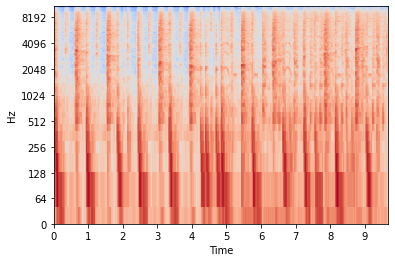

In [30]:
# This block of code is not my code.
# Source: https://github.com/markostam/audio-deepdream-tf/blob/master/deep_audio_dreams.ipynb

hop = consts.MEL_HOP_LEN
y_stft: np.ndarray = melspectrogram(
    y=sample,
    sr=consts.SAMPLE_RATE,
    n_fft=consts.NUM_FFT,
    hop_length=consts.MEL_HOP_LEN,
    n_mels=consts.NUM_MELS,
    win_length=consts.MEL_WINDOW_LEN
)

# Separate the magnitude and phase
# y_stft_mag1, y_stft_ang = librosa.magphase(y_stft)

# Scale the spectrogram such that its values correspond to 0-255 (16-bit rgb amplitude)
nonlin = 1.0 / 8.0

y_stft_mag = np.power(y_stft, nonlin)
y_stft_mag = np.flipud((1 - y_stft_mag / y_stft_mag.max()))
y_stft_mag_rgb = np.zeros([y_stft_mag.shape[0], y_stft_mag.shape[1], 3])
y_stft_mag_rgb[:, :, 0] = y_stft_mag
y_stft_mag_rgb[:, :, 1] = y_stft_mag
y_stft_mag_rgb[:, :, 2] = y_stft_mag

img = 255 * y_stft_mag_rgb

# Show original audio log magnitude spectrogram
librosa.display.specshow(data=np.log(np.abs(y_stft)), sr=consts.SAMPLE_RATE, x_axis='time', y_axis='log')
base_shape: Tensor = tf.shape(img)[:-1]  # Original size of image shape, used to resize final deepdream.

plt.show()

In [31]:
# Maximize the activations of these layers.
layer_names: List[str] = [
    'mixed1',
    'mixed10'
]

deep_dreamer = DeepDreamer(layer_names)

In [32]:
# Change settings below to achieve different results.
dreamified_image: Tensor = deep_dreamer.dreamify(
    _img=img,
    steps_per_octave=1,
    step_size=0.02,
    octaves=range(-2, 5),
    octave_scale=1.3,
)

# Clear anything that might have been draw such as warnings.
display.clear_output(wait=True)

dreamified_image = tf.image.resize(dreamified_image, base_shape)  # Resize image to original image size.
dreamified_image = tf.image.convert_image_dtype(dreamified_image / 255.0, dtype=tf.uint8)

(128, 417)


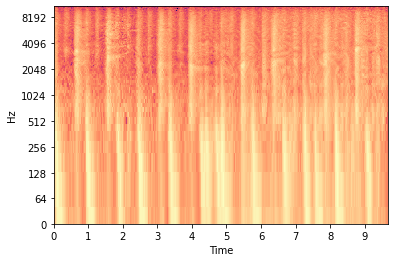

In [33]:
from librosa.feature.inverse import mel_to_audio

# This block of code is not my code.
# Source: https://github.com/markostam/audio-deepdream-tf/blob/master/deep_audio_dreams.ipynb

# Undo processing to bring the image back from 0-255 to original scale.
deepdream_out = np.flipud(dreamified_image)
deepdream_out = (1 - deepdream_out) * y_stft_mag.max()
deepdream_out = np.power(deepdream_out, 1 / nonlin)

# Flatten the three channels and normalize over number of channels.
deepdream_out = np.sum(deepdream_out, axis=2) / 3.0

# Show the new log-spectrogram.
librosa.display.specshow(np.log(np.abs(deepdream_out)), sr=consts.SAMPLE_RATE, x_axis='time', y_axis='log')
plt.show()

# add back in the original phase
deepdream_out_orig = deepdream_out.copy()
deepdream_out = mel_to_audio(
    deepdream_out,
    sr=consts.SAMPLE_RATE,
    n_iter=consts.MEL_TO_AUDIO_N_ITERATIONS
)

In [35]:
create_audio_player(deepdream_out, normalize=True)

In [36]:
write(join(PATH_TO_AUDIO, 'break-beat-dreamified.wav'), deepdream_out, samplerate=consts.SAMPLE_RATE)